<a href="https://colab.research.google.com/github/schwallergroup/ai4chem_course/blob/main/notebooks/04%20-%20Unsupervised%20Learning/palladium_dimers_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accelerating palladium catalyst discovery: a practical application of unsupervised learning

## Table of content

1. Problem introduction
2. General clustering
3. DFT-specific descriptors
4. Final Clustering
5. Experimental validation

In this tutorial we will see how a simple algorithm like k-means can be used to discover new catalysts using few experimental data to guide the next experiments. We will see how a clever use of ML-techniques is able to reveal unintuitive patterns and suggest experiments that would be otherwise ignored.

The notebook is based on the work of Hueffel et al. and was published in this [Science](https://www.science.org/doi/full/10.1126/science.abj0999) article in 2021.

# 0. Relevant packages



Install usual packages and download the datasets.

In [4]:
! pip install scikit-learn pandas numpy matplotlib seaborn scipy tqdm

! mkdir data
! wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/04%20-%20Unsupervised%20Learning/data/LKB_P.csv -O data/LKB_P.csv
! wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/04%20-%20Unsupervised%20Learning/data/Dimer_LKB_P.csv -O data/Dimer_LKB_P.csv

--2025-02-02 23:12:54--  https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/04%20-%20Unsupervised%20Learning/data/LKB_P.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70133 (68K) [text/plain]
Saving to: ‘data/LKB_P.csv’

data/LKB_P.csv      100%[===================>]  68.49K  --.-KB/s    in 0.02s   

2025-02-02 23:12:54 (3.13 MB/s) - ‘data/LKB_P.csv’ saved [70133/70133]

--2025-02-02 23:12:54--  https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/04%20-%20Unsupervised%20Learning/data/Dimer_LKB_P.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.1

# 1. Problem introduction

`Metal speciation` (the distribution of a metal in different physical and chemical forms) is a key property in homogeneous catalysis. This feature plays a crucial role in determining catalyst properties like reactivity or selectivity. Ligands are one of the factors related to metal speciation. Despite the common assumption that structure and reactvity are correlated, the impact of the ligand on catalytic activity is not fully understood, hampering the design of new catalysts.

<div align="left">
<img src="https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/04%20-%20Unsupervised%20Learning/img/speciation.png?raw=1" width="400"/>
</div>

Palladium-catalyzed reactions are one of the most representative transformations involving homogeneous catalysts. Despite the majority of catalytic cycles involve Pd(0) and Pd(II) species, Pd(I) dimers with the [Pd(I)(&mu;-X)P(t-Bu)<sub>3</sub>]<sub>2</sub> motif are specially interesting due to their stability and catalytic performance. However, it is not fully understood why certain ligands favor Pd(I) dimers while others do not, so only few examples of this type of compounds were known.

<div align="left">
<img src="https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/04%20-%20Unsupervised%20Learning/img/pd.png?raw=1" width="400"/>
</div>

The common strategy to discover new species is trial and error. Only 4 ligands promoting Pd(I) state had been discovered using this approach. Different attempts to overcome these limitations were tried. PCA decomposition using 28 general descriptors from a set of 348 monodentate phospine ligands was not able to derive ligand-speciation relationships. On the other hand, DFT calculation of the coprorportionation energy of Pd(0) with Pd(II) to Pd(I) suggested that high exergonicity was related to Pd(I) formation. However, the associated energy of PdCy<sub>3</sub> (non-inducing Pd(I) ligand) was rougly the same than the known Pd(I)-inducing phosphines, thus invalidating this hypothesis.

<div align="left">
<img src="https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/04%20-%20Unsupervised%20Learning/img/PdDFT.png?raw=1" width="400"/>
</div>

Given the few experimental points we have, *could we use unsupervised learning to leverage this knowledge and propose new candidate ligands for Pd(I) dimers discovery?*


## Exercise 1
As a first exercise, we will load the dataframe containing the 348 phosphine ligands and the general descriptors. Each molecule is also classified in one of 8 categories describing the type of ligand. The first 4 principal components of the data are also included. We will verify that PCA is unable to give good insight to the data.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load ligand information
ligands = pd.read_csv('data/LKB_P.csv', sep=';')

ligands.head()

,No.,Type,E(HOMO),E(LUMO),He8_steric,PA,Q(B),BE(B),P-B,DP-A(B),...,BE(Pt),P-Pt,DP-A(Pt),DA-P-A(Pt),<(H3P)Pt(PH3),S4',PC1,PC2,PC3,PC4
0,1,R,-0.24636,-0.00029,2.30,190.60,-0.590,26.10,1.941,-0.013,...,8.80,2.328,-0.001,1.5,109.4,66.9,-3.078,0.798,6.079,-1.066
1,2,R,-0.19045,0.03268,3.00,233.00,-0.680,39.20,1.926,-0.028,...,12.90,2.331,-0.010,1.3,107.5,39.4,1.602,3.976,1.536,0.090
2,3,R,-0.27742,-0.05837,3.00,182.30,-0.560,26.30,1.915,-0.002,...,22.80,2.250,0.008,-0.1,109.0,52.2,-7.226,-3.302,2.929,2.032
3,4,R,-0.26620,-0.11270,20.66,194.04,-0.538,22.51,1.924,-0.005,...,16.58,2.260,0.046,-2.4,106.6,28.7,-6.715,-9.291,1.348,-0.823
4,5,R,-0.18723,0.02584,6.00,239.10,-0.680,39.00,1.934,-0.027,...,17.10,2.338,-0.010,1.6,107.4,39.0,2.280,3.408,1.584,0.168


Now, plot the ligands using PC1 and PC2, displaying also the ligand label (from the 'Type' column).

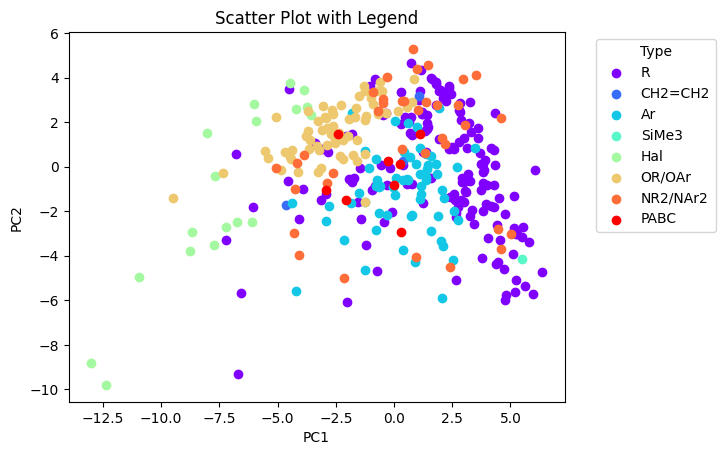

In [6]:
import numpy as np
#YOUR CODE
# Create a colormap for the unique types
unique_types = ligands['Type'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_types)))  # Assign a unique color to each type
color_map = dict(zip(unique_types, colors))  # Map each type to a color

# Assign colors based on 'Type'
ligands['Color'] = ligands['Type'].map(color_map)

# Plot scatter with colors
for type_label, color in color_map.items():
    subset = ligands[ligands['Type'] == type_label]
    plt.scatter(subset["PC1"], subset["PC2"], label=type_label, color=color)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scatter Plot with Legend")

# Add legend
plt.legend(title="Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Verify that the PCA decomposition is unable to separate Pd(I) inducing ligands from the non-inducing ligand. For this purpose, plot the dataset again and remark the datapoints that correspond to the target ligands.

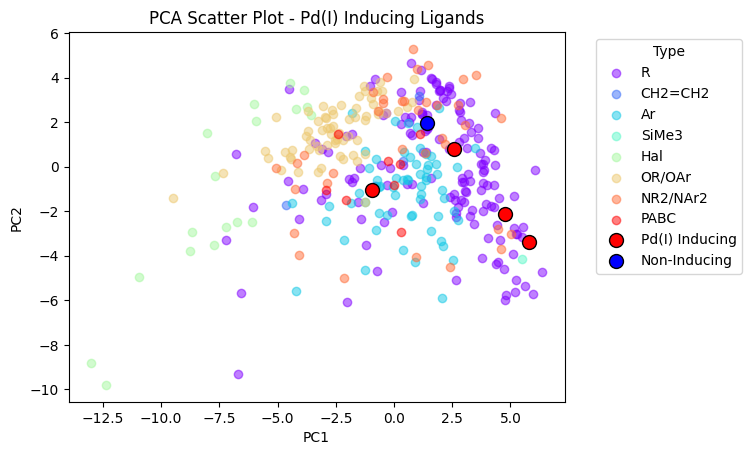

In [7]:
#These are the indices of the positive (Pd(I) inducing) and negative ligands
pos_refs = [16, 41, 54, 113]
neg_refs = [21]

#YOUR CODE
# Create a colormap for the unique types
unique_types = ligands['Type'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_types)))  # Assign a unique color to each type
color_map = dict(zip(unique_types, colors))  # Map each type to a color

# Assign colors based on 'Type'
ligands['Color'] = ligands['Type'].map(color_map)

# Plot all data points
for type_label, color in color_map.items():
    subset = ligands[ligands['Type'] == type_label]
    plt.scatter(subset["PC1"], subset["PC2"], label=type_label, color=color, alpha=0.5)

# Highlight positive Pd(I) inducing ligands
plt.scatter(ligands.loc[pos_refs, "PC1"], ligands.loc[pos_refs, "PC2"],
            color='red', edgecolors='black', s=100, label="Pd(I) Inducing")

# Highlight negative ligand
plt.scatter(ligands.loc[neg_refs, "PC1"], ligands.loc[neg_refs, "PC2"],
            color='blue', edgecolors='black', s=100, label="Non-Inducing")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter Plot - Pd(I) Inducing Ligands")

# Add legend
plt.legend(title="Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

You can clearly see how we are not able to extract clear information from PCA. Two of the Pd(I)-inducing ligands are closer to the non-inducing ligand than to the other known ligands, indicating that this analysis is not enough to suggest new species.

# 2. General property clustering

Time to change the approach! First, we will see if k-means algorithm is able to cluster our ligands efficiently. This will allow us to reduce the number of possible molecules we have to consider for experimental screening.

Try to run a k-Means clustering on the data using different values of k and select the best parameters based on the inertia, distorition and silhouette score.

In [8]:
from sklearn.cluster import KMeans
# Here we provide the columns you should use. First, you should standardize the data
process = ['E(HOMO)', 'E(LUMO)', 'He8_steric', 'PA', 'Q(B)', 'BE(B)', 'P-B', 'DP-A(B)', 'DA-P-A(B)', 'Q(Au)', 'BE(Au)',
           'Au-Cl', 'Au-P', 'DP-A(Au)', 'DA-P-A(Au)', 'Q(Pd)', 'BE(Pd)', 'Pd-Cl trans', 'P-Pd', 'DP-A(Pd)',
           'DA-P-A(Pd)', 'Q(Pt)', 'BE(Pt)', 'P-Pt', 'DP-A(Pt)', 'DA-P-A(Pt)', '<(H3P)Pt(PH3)', "S4'"]
# Columns in the data set to exclude from clustering
drop = ['Type', "PC1", "PC2", "PC3", "PC4"]

###YORU CODE
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=10, init='k-means++', random_state=42)
kmeans.fit(ligands[process])



KMeans(n_clusters=4, n_init=10)

Plot metrics to select the best k based on this analysis.

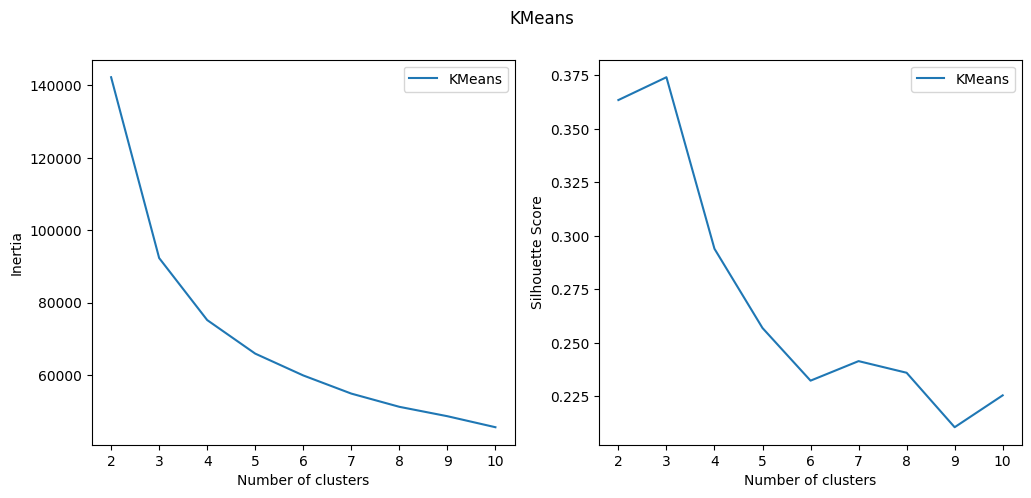

In [12]:
### YOUR CODE
from sklearn.metrics import silhouette_score

min_clusters = 2
max_clusters = 10
#KMeans(n_clusters=n_clusters, n_init=10, init='k-means++', random_state=42)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'{"KMeans"}')
inertia = []
silhouette_scores = []
for n_clusters in range(min_clusters, max_clusters + 1):
  kmeans.set_params(n_clusters=n_clusters)
  labels = kmeans.fit_predict(ligands[process])
  inertia.append(kmeans.inertia_)
  silhouette_scores.append(silhouette_score(ligands[process], labels))
ax1.plot(range(min_clusters, max_clusters + 1), inertia, label="KMeans")
ax2.plot(range(min_clusters, max_clusters + 1), silhouette_scores, label="KMeans")

ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Inertia")
ax1.legend()

ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Silhouette Score")
ax2.legend()

plt.show()

The inertia and distortin method do not suggest a clear k. Silhouette method may suggest an optimal k around 7.

## Optional

In the original publication, they choose an optimal number of clusters equal to 8 (due to the similar scores achieved by k between 6 and 8 and the fact that the original classes of ligands was 8). Build a k-Means model with k=8 and fit it with 1000 different random seeds. Then, count how many times each ligand is grouped in the same cluster of the positive (Pd(I)-inducing) ligands.

In [ ]:
## YOUR CODE

This way we obtain a statistics dataframe that can be used to filter the ligands based on the Score (normalized number of times that a given ligand is clustered with the reference ligands). Take the ligands that are grouped with the positive group more than 75% of the time.

In [ ]:
## YOUR CODE

Visualize the indices of the clustered ligands and verify that number 21 (non-inducing ligand) is not included in this group. This array of indices can be used to select and filter the original data.

In [ ]:
## YOUR CODE

Check also that this group of ligands contains mixed ligand types.

In [ ]:
## YOUR CODE

Great! We have got rid of the nasty non-inducing ligand. Besides, our selected cluster now contains different types of ligands. This is a good first step.

# 3. DFT-specific descriptors

The first clustering reduced the candidate ligands space to ~25% of the original size, keeping 89 ligands from the list of 348. A subsequent k-means clustering using the general descriptors in order to refine this first filtering failed. Therefore, the descriptors needed to be tuned for this specific problem. DFT-specific descriptors related to the Pd(I) iodine bridge were calculated and included in the dataset (a total of 42 new descriptors).

We will not calculate all the DFT descriptors, but just load the dataset containing the refined ligands. This dataframe only contains 66 ligands as the calculations were only done for ligands containing P-C bonds.

In [ ]:
#Load and visualize the dataframe containing DFT-specific descriptors (the Dimer_LKB_P.csv file)
## YOUR CODE


,No.,Type,E(HOMO),E(LUMO),He8_steric,PA,Q(Pd),BE(Pd),Pd-Cl trans,P-Pd,...,G_NBO_Pd,G_NBO_P,G_LENGTH_Pd_P,G_LENGTH_Pd_Pd,G_TORSION_Pd_I_I_Pd,G_ORDER_Pd_Pd,PC1',PC2',PC3',PC4'
0,15,R,-0.17500,0.02350,37.82,247.52,-1.257,30.03,2.379,2.337,...,-0.379685,1.297005,2.312152,3.226557,103.059842,0.1171,-0.986788,0.414056,0.017615,-0.632639
1,16,R,-0.17267,0.02754,23.38,250.80,-1.200,23.90,2.382,2.418,...,-0.278010,1.232615,2.413734,4.305073,174.451579,0.0264,1.198717,1.162347,0.901051,-0.055612
2,19,R,-0.18340,0.01900,31.31,243.63,-1.282,28.25,2.377,2.308,...,-0.340260,1.205245,2.314010,3.620629,124.149654,0.0713,-0.146169,-0.318877,0.877642,-0.227544
3,36,R,-0.17840,0.02300,19.69,245.86,-1.275,34.79,2.379,2.321,...,-0.365385,1.280040,2.317294,3.187955,101.341176,0.1254,-1.135555,0.275201,0.181931,-0.516078
4,37,R,-0.17790,0.02220,18.53,246.58,-1.253,35.72,2.380,2.334,...,-0.387150,1.284050,2.346424,3.102411,95.391197,0.1369,-0.904739,0.447820,0.106396,-0.301205


# 4. Final clustering: unraveling new ligands

Once the new descriptors were calculated, we can try a second k-Means clustering to see if we can reduce even more our candidate space. Repeat the same clusterig process to select the optimum k.

In [ ]:
# Columns in the data set to exclude
drop = ["Type", "PC1", "PC2", "PC3", "PC4", "PC1'", "PC2'", "PC3'", "PC4'"]

#adjust the references of the positive ligands in the new dataframe
refs = [1, 8, 18, 36]

## YOUR CODE

Plot the metrics

In [ ]:
## YOUR CODE

In this case, the metrics again do not seem very informative.

## Optional

In the original publication, they choose an optimal number of clusters equal to 6. Build a k-Means model with k=6 and fit it with 1000 different random seeds. Then, count how many times each ligand is grouped in the same cluster of the positive ligands.

In [ ]:
## YOUR CODE

Now, select the ligands that are grouped in the same clusters than our reference ligands more than 50% of the time.

In [ ]:
## YOUR CODE

# 5. Experimental validation

The second clustering grouped 21 new ligands together with the 4 already known Pd(I) dimer-inducer ligands. These predictions were tested experimentally, and these were the results:

<div align="left">
<img src="https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/04%20-%20Unsupervised%20Learning/img/exp_validation.png?raw=1" width="400"/>
</div>

8 new dimers were discovered! Quite an impressive result given the low amount of previous data and the poor understanding of ligand-speciation relationship. You can check the structures of the proposed ligands in the SI of the original paper, and realize how different these molecules are. Probably, a human researcher would have discarded them, but ML was able to point out the similarities and provide meaningful counterintuitive experimental suggestions.

# Conclusion

In this notebook, you have seen how a simple algorithm like k-means can be very powerful if applied wisely. Researchers at the interface of ML and Chemistry can combine both domains to obtain impressive results. We hope this example motivates you to keep learning more!

Finally, [here](https://github.com/J-Hueffel/PdDimer) is the repo from the original publication, in case you want to check the code. We would also like to acknowledge the [Schoenebeck](https://www.schoenebeck.oc.rwth-aachen.de/) group for this fantastic work.